#Generate data

In [345]:
import numpy as np
import random

# returns a matrix with the desired dimensions
def get_matrix(n, m):
    if m == None:
      m==n

    return np.zeros((n, m))


def get_points(n, m):
    
    # choose 2 points at random for gausion distribution centers
    p1 = (random.randint(1, 8), random.randint(1, 8))
    p2 = (random.randint(1, 8), random.randint(1, 8))

    while p1[0] == 1 and p1[1] == 1:
       p1 = (random.randint(1, 8), random.randint(1, 8))

    # No Duplicates
    while (p1[0] == p2[0] and p1[1] == p2[1]) or (p2[0] == 1 and p2[1] == 1):
      p2 = (random.randint(1, 8), random.randint(1, 8))

    return [p1, p2]

def populate_distribution(mat, points):

    #get dims
    n = len(mat)
    m = len(mat[0])

    p1 = points[0]
    p2 = points[1]

    print(p1, p2)

    # use a 3x3 gaussian kernal
    if n > 4:
      kern = [[0.0625, 0.125, 0.0625],
              [0.125, 0.25, 0.125],
              [0.0625, 0.125, 0.0625]]
      
      for ind1, row in enumerate(kern):
        for ind2, val in enumerate(row):
           mat[p1[0]-1+ind1][p1[1]-1+ind2] += val/2

      for ind1, row in enumerate(kern):
        for ind2, val in enumerate(row):
           mat[p2[0]-1+ind1][p2[1]-1+ind2] += val/2

    else:
      mat[p1[0]][p1[1]] = 0.5
      mat[p2[0]][p2[1]] = 0.5

    return mat

def define_a_target(mat):
    # choose a target from the 3d distribution

    i = 0
    j = 0

    # pick a random number n 0 to 1
    # traverse the graph summing cells unitl sum > n

    n = random.uniform(0, 1)
    print(n)
    sum = 0

    point = None


    for (index1, i) in enumerate(mat):
      for (index2, j) in  enumerate(i):
        sum+=j
        if (sum > n and point == None):
          point = (index1, index2)

    return point

def validate_sum(mat):
  sum = 0
  for row in mat:
      for val in row:
         sum += val
    
  print('sum = ', sum)

def create_visual_aid(mat, target):
  print(target)
  temp = mat[target[0]][ target[1]]
  mat[target[0]][ target[1]] = 8
  for row in mat:
    print(row)
  mat[target[0]][ target[1]] = temp

def get_populated_map(map_dim):
  mat = get_matrix(map_dim, map_dim)
  points = get_points(map_dim, map_dim)
  mat = populate_distribution(mat, points)
  validate_sum(mat)
  return mat


In [346]:
map_dim = 10
tail_len = 3
start = (0,0)

mat = get_populated_map(map_dim)

target = define_a_target(mat)
va = create_visual_aid(mat, target)


(5, 7) (7, 1)
sum =  1.0
0.8680656282893529
(7, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.      0.      0.      0.      0.      0.      0.03125 0.0625  0.03125
 0.     ]
[0.     0.     0.     0.     0.     0.     0.0625 0.125  0.0625 0.    ]
[0.03125 0.0625  0.03125 0.      0.      0.      0.03125 0.0625  0.03125
 0.     ]
[0.0625 0.125  8.     0.     0.     0.     0.     0.     0.     0.    ]
[0.03125 0.0625  0.03125 0.      0.      0.      0.      0.      0.
 0.     ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#Update probability distribution

In [347]:
#params
ed = 0.05   # missed detection
ef = 0.01   # false alarm


# takes in the probability distribution matrix and the current square as arguments
# returns updated matrix
def update_probability_distribution(mat, curr, verbose=0):

  # calculate bi
  bi = ed*mat[curr[0]][curr[1]]+(1-ef)*(1-mat[curr[0]][curr[1]])

  for (row, vec) in enumerate(mat):
    for (col, item) in enumerate(mat[row]):
      if item > 0:
        if curr[0] == row and curr[1] == col:
          mat[row][col] *= (ed/bi)
        else:
          mat[row][col] *= ((1 - ef)/bi)

  if verbose != 0:
    sum = np.sum(mat)
    if sum > 1.0001 or sum < 0.9999:
      print("sum was not 1, sum was: ", sum)
      print(mat)
    else:
      print("good job")
      print(mat)

  return mat



In [348]:
mat2 = update_probability_distribution(mat, (2, 8), 1)
print(mat2)

good job
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.03125 0.0625  0.03125
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.0625  0.125   0.0625
  0.     ]
 [0.03125 0.0625  0.03125 0.      0.      0.      0.03125 0.0625  0.03125
  0.     ]
 [0.0625  0.125   0.0625  0.      0.      0.      0.      0.      0.
  0.     ]
 [0.03125 0.0625  0.03125 0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]]
[[0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.     ]
 [0.      0.    

# Reward Policy

Finding the target: + 50

Incentive to win quickly: + 50 - number of moves

Going out of bounds: -50

Timing out: -50

# Prepping For Graphs

In [349]:
game_results=[]
TTW = [] #time to win
TTWMA = []
total_games = 0

wins = 0
oob = 0
timeout = 0

history_wins = []
history_OOB = []
history_timeout = []


win_percentage = []
OOB_percentage = []
timeout_percentage = []

win_window_50 = []
oob_window_50 = []
timeout_window_50 = []

avg_TTW = 0

#Modified Snake Game

In [350]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame.init()
#font = pygame.font.Font('arial.ttf', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)
GOLD = (255, 215, 0)
RED = []

num = 255
for x in range(1, 11):
   RED.append((num, 0, 0))
   num -= 25
RED.reverse()


BLOCK_SIZE = 25
BORDER_SIZE = 10
MINI_BLOCK_SIZE = BLOCK_SIZE - BORDER_SIZE

SCALER = 5

BLOCK_SIZE = BLOCK_SIZE*SCALER
BORDER_SIZE = BORDER_SIZE*SCALER/2
MINI_BLOCK_SIZE = MINI_BLOCK_SIZE*SCALER

SPEED = 40

WIDTH = BLOCK_SIZE * map_dim
HEIGHT = BLOCK_SIZE * map_dim

ed = 0.05   # missed detection
ef = 0.01   # false alarm

class SnakeGameAI:

    def __init__(self):
        self.w = WIDTH
        self.h = HEIGHT
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Drone')
        self.clock = pygame.time.Clock()
        self.reset()


    def reset(self):
        self.drone = Point(0, 0)
        self.drone_map = (0, 0)
        self.score = 0
        self.target = None
        self.target_map = None
        self.map = self._gen_map()
        self.visited_map = get_matrix(10,10)
        self.map_sum = np.add(self.map, self.visited_map)
        self._place_target()
        self.frame_iteration = 0
        self.tail = []
        self.tail_max_len = tail_len


    def _place_target(self):
        # choose a target from the 3d distribution
        i = 0
        j = 0

        # pick a random number n between 0 to 1
        # traverse the graph summing cells until sum > n
        n = random.uniform(0, 1)
        print(n)
        sum = 0
        point = None
        for (index1, i) in enumerate(self.map):
          for (index2, j) in  enumerate(i):
            sum += j
            if (sum > n and point == None):
              point = (index1, index2)

        self.target_map = point
        self.target = Point(point[0]*BLOCK_SIZE, point[1]*BLOCK_SIZE)
        return
    
    def prepare_data_for_graphs(self):
        global oob
        global wins
        global timeout
        global total_games

        total_games+=1
        history_wins.append(wins)
        history_OOB.append(oob)
        history_timeout.append(timeout)

        OOB_percentage.append(oob/total_games)
        win_percentage.append(wins/total_games)
        timeout_percentage.append(timeout/total_games)
        
        if len(game_results) > 50:
            rec50 = game_results[-50:]
            num_wins = rec50.count(2)
            num_oob = rec50.count(1)
            num_timeout = rec50.count(3)
            win_window_50.append(num_wins/50)
            oob_window_50.append(num_oob/50)
            timeout_window_50.append(num_timeout/50)
        else: 
            leng = len(game_results)
            num_wins = game_results.count(2)
            num_oob = game_results.count(1)
            num_timeout = game_results.count(3)
            win_window_50.append(num_wins/leng)
            oob_window_50.append(num_oob/leng)
            timeout_window_50.append(num_timeout/leng)
        return
    
    def prepare_TTW_graph(self):
        TTW.append(self.frame_iteration)
        if len(TTW) >= 30:
            res = TTW[-30:]
            TTWMA.append(np.average(res))
        else:
            TTWMA.append(np.average(TTW))
        return    

    def play_step(self, action):
        self.frame_iteration += 1
        self.score += 1
        reward = -1
        game_over = False

        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()


        # 2. move
        prev = self._move(action) # update the drone location
        global oob
        global wins
        global timeout
    
        self.visited_map[prev[0]][prev[1]] -=0.2

        #3. check if out of bounds
        if self.is_collision():
            print("OOB")
            game_over = True
            reward = -900
            game_results.append(1)
            oob += 1

            self.prepare_data_for_graphs()

            return reward, game_over, self.score


        # 4. check if target found
        if self.drone_map[0] == self.target_map[0] and self.drone_map[1] == self.target_map[1]:
            print("WIN")
            game_over = True
            reward = 100 + self.map[self.drone_map[0]][self.drone_map[1]]*1000
            game_results.append(2)
            wins+=1
            
            self.prepare_data_for_graphs()
            self.prepare_TTW_graph()

            return reward, game_over, self.score

        # 5. To prevent the agent from going in circles and never ending
        #    limit game to 100 moves
        if self.frame_iteration == 300:
            print("TO")
            game_over = True
            reward = -1
            game_results.append(3)
            timeout += 1

            self.prepare_data_for_graphs()
          
            return reward, game_over, self.score


        # 6. Check if stepping on tail
        if self.visited_map[self.drone_map[0]][self.drone_map[1]] < 0:
           print("revisited space")
           reward += self.visited_map[self.drone_map[0]][self.drone_map[1]]*1000

        # 7. reward for checking a high probability space
        reward += self.map[self.drone_map[0]][self.drone_map[1]]*2000

        print('reward = ', reward)

        # 8. update ui and clock and map
        if self.map[self.drone_map[0]][self.drone_map[1]] > 0:
            self._update_probability_dist()
        self.map_sum = np.add(self.map, self.visited_map)
        self._update_ui()
        self.clock.tick(SPEED)


        # 9. return game over and score
        return reward, game_over, self.score


    def is_collision(self, pt=None):
        if pt is None:
            pt = self.drone
        # hits boundary
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        return False


    def _update_ui(self):
        # fill the background with black
        self.display.fill(BLACK)

        # draw all non zero probability spaces
        for (row, vec) in enumerate(self.map_sum):
          for (col, item) in enumerate(self.map_sum[row]):
            if self.map_sum[row][col] > 0:
              GREEN = (0, int(round((item*200+55))), 0)
              pygame.draw.rect(self.display, GREEN, pygame.Rect(col*BLOCK_SIZE, row*BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
            elif self.map_sum[row][col] < 0:
              red_val = int(round((item*-100+55)))
              if red_val > 255:
                red_val = 255
              RED = (red_val, 0, 0)
              pygame.draw.rect(self.display, RED, pygame.Rect(col*BLOCK_SIZE, row*BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

        # draw the target
        pygame.draw.rect(self.display, GOLD, pygame.Rect(self.target.y+BORDER_SIZE, self.target.x+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # draw the revisit penalty
        for indx1, row in enumerate(self.map):
          for indx2, val in enumerate(row):
            if val < 0:
                shade = int(round(val*-10))-1
                print("shade, val = ",shade, val)
                if shade < 0:
                  shade = 0
                if shade >= 10:
                   shade = 9      
                pygame.draw.rect(self.display, RED[shade], pygame.Rect(indx2*BLOCK_SIZE, indx1*BLOCK_SIZE,BLOCK_SIZE, BLOCK_SIZE))

        # draw the droan
        #pygame.draw.rect(self.display, BLUE1, pygame.Rect(self.drone.x, self.drone.y, BLOCK_SIZE, BLOCK_SIZE))
        pygame.draw.rect(self.display, BLUE2, pygame.Rect(self.drone.x+BORDER_SIZE, self.drone.y+BORDER_SIZE, MINI_BLOCK_SIZE, MINI_BLOCK_SIZE))

        # text = font.render("Score: " + str(self.score), True, WHITE)
        # self.display.blit(text, [0, 0])
        pygame.display.flip()


    def _update_probability_dist(self):
        curr = self.drone_map
        bi = ed*self.map[curr[0]][curr[1]]+(1-ef)*(1-self.map[curr[0]][curr[1]])

        for (row, vec) in enumerate(self.map):
          for (col, item) in enumerate(self.map[row]):
            if item > 0:
              if curr[0] == row and curr[1] == col:
                self.map[row][col] *= (ed/bi)
              else:
                self.map[row][col] *= ((1 - ef)/bi)

    def _move(self, action):

        prev = self.drone_map

        # transform coordinates
        x = self.drone.x
        y = self.drone.y
        col = self.drone_map[1]
        row = self.drone_map[0]

        # move the points
        if np.array_equal(action, [1, 0, 0, 0]):
            x += BLOCK_SIZE
            col += 1
            print("right")
        elif np.array_equal(action, [0, 1, 0, 0]):
            x -= BLOCK_SIZE
            col -= 1
            print("left")
        elif np.array_equal(action, [0, 0, 1, 0]):
            y += BLOCK_SIZE
            row += 1
            print("down")
        elif np.array_equal(action, [0, 0, 0, 1]):
            y -= BLOCK_SIZE
            row -= 1
            print("up")
        else: # [0, 0, 0, 0, 1]
            print("STAY")

        # update the coordinataes
        self.drone = Point(x, y)
        self.drone_map = (row, col)

        return prev


    def _gen_map(self):
        mat = get_matrix(map_dim, map_dim)
        points = get_points(map_dim, map_dim)
        mat = populate_distribution(mat, points)
        return mat


In [351]:
print(RED)

[(30, 0, 0), (55, 0, 0), (80, 0, 0), (105, 0, 0), (130, 0, 0), (155, 0, 0), (180, 0, 0), (205, 0, 0), (230, 0, 0), (255, 0, 0)]


# PyTorch model

In [352]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        targ = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            targ[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(targ, pred)
        loss.backward()

        self.optimizer.step()

# helper functions

In [353]:
import matplotlib.pyplot as plt
from IPython import display

def tuple2onehot(tuple):
    onehot_x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    onehot_y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if tuple[1] >= 0 and tuple[1] < 10:
        onehot_x[tuple[1]] = 1
    if tuple[0] >= 0 and tuple[0] < 10:
        onehot_y[tuple[0]] = 1
    return onehot_x, onehot_y


In [354]:
def get_probability_up(mat, loc):
    prob=0
    if(loc[0] == 0):
        return 0
    else:
        idx = 0
        while idx < loc[0]:
            row = mat[idx]
            prob = prob + sum(row)
            idx += 1
    return prob

def get_probability_down(mat, loc):
    prob=0
    if(loc[0] == 9):
        return 0
    else:
        idx = 9
        while idx > loc[0]:
            row = mat[idx]
            prob = prob + sum(row)
            idx -= 1
    return prob

map_dim = 10
tail_len = 12
start = (0,0)

mat = get_populated_map(map_dim)
loc = (4, 4)
for i in range(0, 3):
    mat = [list(reversed(col)) for col in zip(*mat)]


va = create_visual_aid(mat, loc)
print(get_probability_up(mat, loc))
print(get_probability_down(mat, loc))
rotated = [list(reversed(col)) for col in zip(*mat)]
loc = (loc[1], 9-loc[0])
print(get_probability_down(rotated, loc))
print(get_probability_up(rotated, loc))

(4, 7) (1, 7)
sum =  1.0
(4, 4)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.03125, 0.0625, 0.03125, 0.03125, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0]
[0.0625, 0.125, 0.0625, 0.0625, 0.125, 0.0625, 0.0, 0.0, 0.0, 0.0]
[0.03125, 0.0625, 0.03125, 0.03125, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 8, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1.0
0.0
0.125
0.625


# Agent

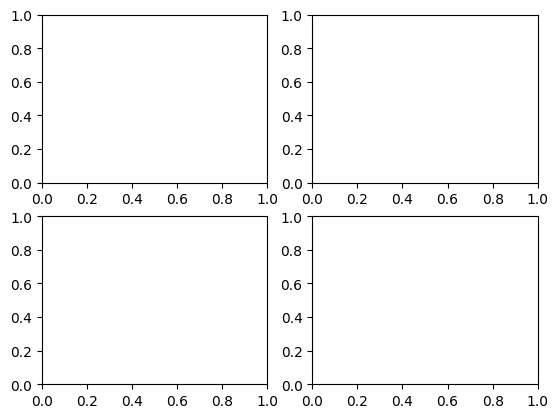

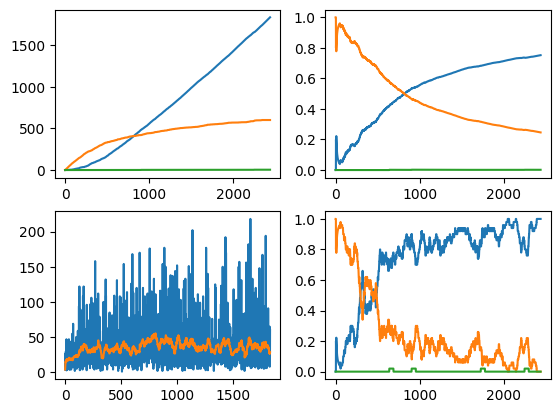

<Figure size 1500x1500 with 0 Axes>

right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
right
reward =  -1.0
down
reward =  -1.0
left
reward =  -1.0
left
reward =  -1.0


KeyboardInterrupt: 

In [355]:
import torch
import random
import numpy as np
from collections import deque
import copy

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.05

input_dim = map_dim*map_dim + 20 + 8 #map + position + tail + probability_mat + danger_mat
hidden_dim = 512
output_dim = 4 # up, down, right, left

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.99 # discount rate
        self.memory = deque(maxlen = MAX_MEMORY) # popleft()
        self.model = Linear_QNet(input_dim, hidden_dim, output_dim)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        drone = game.drone_map
        tail = game.tail
        drone_x, drone_y = tuple2onehot(drone)
        state = np.append(np.array(game.map_sum).flatten(), drone_x)
        state = np.append(np.array(state).flatten(), drone_y)
        
        mat = copy.deepcopy(game.map)
        loc = game.drone_map

        prob_mat = [0, 0, 0, 0]
        prob_mat[0] = get_probability_up(mat, loc)
        prob_mat[1] = get_probability_down(mat, loc)
        rotated = [list(reversed(col)) for col in zip(*mat)]
        loc = (loc[1], 9-loc[0])
        prob_mat[2] = get_probability_down(rotated, loc)
        prob_mat[3] = get_probability_up(rotated, loc)
        
        danger_mat = [0, 0, 0, 0]
        danger_mat[0] = drone_x[0]
        danger_mat[1] = drone_x[9]
        danger_mat[2] = drone_y[0]
        danger_mat[3] = drone_y[9]


        state = np.append(np.array(state).flatten(), prob_mat)
        state = np.append(np.array(state).flatten(), danger_mat)

        return np.array(state)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        # for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        #print(type(state), type(action), type(reward), type(next_state) )
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 66 - (self.n_games/10)
        final_move = [0, 0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 3)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            fig, ax = plt.subplots(2, 2)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            ax[0, 0].plot(history_wins, label='wins')
            ax[0, 0].plot(history_OOB, label='oob')
            ax[0, 0].plot(history_timeout, label='timeout')
            ax[0, 1].plot(win_percentage, label='wins')
            ax[0, 1].plot(OOB_percentage, label='oob')
            ax[0, 1].plot(timeout_percentage, label='timeout')
            ax[1, 0].plot(TTW, label='wins')
            ax[1, 0].plot(TTWMA, label='oob')
            ax[1, 1].plot(win_window_50, label='wins')
            ax[1, 1].plot(oob_window_50, label='oob')
            ax[1, 1].plot(timeout_window_50, label='timeout')
            plt.figure(figsize=(15,15))
            plt.show()



if __name__ == '__main__':
    train()

In [357]:
print(TTWMA[len(TTWMA)-1])
print(win_window_50[len(win_window_50)-1])
print(np.max(win_window_50))

      

28.433333333333334
1.0
1.0


homework 9
quantization

In [ ]:
import numpy as np

# original matrix
om = [[2.10, 0.05, -0.98, -2.0],
     [1.10, -0.2, 0.000, 0.70],
     [0.00, -1.7, 2.300, 1.00],
     [-1.0, 0.50, 3.000, -0.6]]

# quantized matrix
qm = [[ 4, -2, -5, -8],
      [ 1, -3, -2, 0],
      [-2, -7,  5, -8],
      [ -5, -1,  7, -4]]

# reconstructed matrix
rm = (np.asarray(qm) + 2 ) * 0.33333333333
print(rm)
print()


# quantization error
qe = rm - om
print(qe)